# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks using PyTorch
<br>

#### Activity 2a: Implementing a FC for ASL Dataset using PyTorch
<br>


- Objective

    The primary aim of this activity is to transition from using Numpy for network implementation to utilizing PyTorch, a powerful deep learning framework. You will be replicating the work you did for the ASL dataset in Activity 1b, but this time, you'll implement a your multi layer FC model using PyTorch.
    
- Instructions

    Review Previous Work: Begin by reviewing your Numpy-based Fully Connected Network for the ASL dataset from Activity 1b. Note the architecture, hyperparameters, and performance metrics for comparison.

    Introduce PyTorch: If you're new to PyTorch, take some time to familiarize yourself with its basic operations and syntax. You can consult the official documentation or follow online tutorials.

    Prepare the ASL Dataset: As before, download and preprocess the Kaggle ASL dataset. 

    Implement the Network: Design your network architecture tailored for the ASL dataset. Pay special attention to PyTorch modules like nn.Linear() and nn.ReLU().

    Train the Model: Implement the training loop, making use of PyTorch's autograd to handle backpropagation. Monitor metrics like loss and accuracy as the model trains.

    Analyze and Document: In Markdown cells, discuss the architecture choices, any differences in performance between the Numpy and PyTorch implementations, and insights gained from using a deep learning framework like PyTorch.

In [2]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

#PyTorch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F

# Solamente para usuarios de Jupyter Themes
from jupyterthemes import jtplot
jtplot.style(grid=False)

In [3]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/asl_data/'
DATA_PATH = './asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

### Always a good idea to explore the data

In [4]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Get training label data

In [5]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [6]:
print(x_train.shape)
print(y_train.shape)

(27455, 784)
(27455,)


In [7]:
print(x_val.shape, y_val.shape)

(7172, 784) (7172,)


In [8]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    assert x.shape[0] == y.shape[0], 'Number of samples x!= number samples y'
    total_samples = x.shape[0]
    if shuffle:
        idxs = np.arange(x.shape[0])
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        #return x_val, y_val, x_test, y_test
#         return x[:total_samples//2, :], y[:total_samples//2], x[total_samples//2:, :], y[total_samples//2:]
    return x[:int(total_samples*pct), :], y[:int(total_samples*pct)], x[int(total_samples*(pct)):, :], y[int(total_samples*(pct)):]
        

In [9]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [10]:
type(y_val)

numpy.ndarray

In [11]:
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(3586, 784) (3586,)
(3586, 784) (3586,)


In [12]:
alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise the data

In [13]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [14]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)


In [15]:
x_train.mean(), x_train.std()

(3.6268384e-06, 0.99999946)

In [16]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

In [17]:
type(x_val)

numpy.ndarray

La imagen muestreada representa un: s


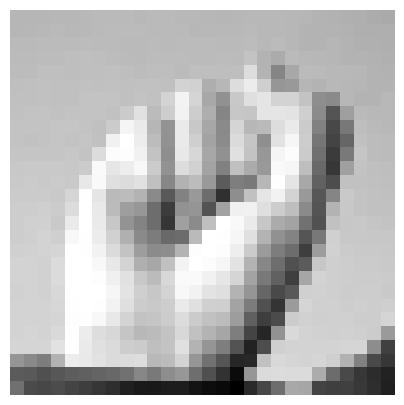

In [18]:
rnd_idx = np.random.randint(len(y_val))
# print(rnd_idx)
# print(y_val[rnd_idx])
print(f'La imagen muestreada representa un: {alphabet[y_val[rnd_idx]]}')
plot_number(x_val[rnd_idx].reshape(28,28))

### The model

$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Create minibatches

In [19]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

In [34]:
for i, (x, y) in enumerate(create_minibatches(128,x_train, y_train)):
    print(i, len(x[0]))

0 784
1 784
2 784
3 784
4 784
5 784
6 784
7 784
8 784
9 784
10 784
11 784
12 784
13 784
14 784
15 784
16 784
17 784
18 784
19 784
20 784
21 784
22 784
23 784
24 784
25 784
26 784
27 784
28 784
29 784
30 784
31 784
32 784
33 784
34 784
35 784
36 784
37 784
38 784
39 784
40 784
41 784
42 784
43 784
44 784
45 784
46 784
47 784
48 784
49 784
50 784
51 784
52 784
53 784
54 784
55 784
56 784
57 784
58 784
59 784
60 784
61 784
62 784
63 784
64 784
65 784
66 784
67 784
68 784
69 784
70 784
71 784
72 784
73 784
74 784
75 784
76 784
77 784
78 784
79 784
80 784
81 784
82 784
83 784
84 784
85 784
86 784
87 784
88 784
89 784
90 784
91 784
92 784
93 784
94 784
95 784
96 784
97 784
98 784
99 784
100 784
101 784
102 784
103 784
104 784
105 784
106 784
107 784
108 784
109 784
110 784
111 784
112 784
113 784
114 784
115 784
116 784
117 784
118 784
119 784
120 784
121 784
122 784
123 784
124 784
125 784
126 784
127 784
128 784
129 784
130 784
131 784
132 784
133 784
134 784
135 784
136 784
137 784
138 78

### Now the PyTorch part

In [21]:
x_train_tensor = torch.tensor(x_train.copy())
y_train_tensor = torch.tensor(y_train.copy())

x_val_tensor = torch.tensor(x_val.copy())
y_val_tensor = torch.tensor(y_val.copy())

x_test_tensor = torch.tensor(x_test.copy())
y_test_tensor = torch.tensor(y_test.copy())

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Accuracy

In [23]:
def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    cost = 0.
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for mb, (xi, yi) in enumerate(create_minibatches(mb_size, x, y),1):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            cost += (F.cross_entropy(scores, yi)).item()
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

        return cost/mb, float(num_correct)/num_total  

### Training Loop

In [24]:
def train(model, optimiser, mb_size, epochs=100):
    model = model.to(device=device)
    train_cost = 0.
    val_cost = 0.
    for epoch in range(epochs):
        train_correct_num  = 0.
        train_total = 0.
        train_cost_acum = 0
        for mb, (xi, yi) in enumerate(create_minibatches(mb_size, x_train_tensor, y_train_tensor), 1):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # funcion cost
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
            train_correct_num += (torch.argmax(scores, dim=1) == yi.squeeze()).sum()
            train_total += scores.size(0)  
            
            train_cost_acum += cost.item()
        
        val_cost, val_acc = accuracy(model, x_val_tensor, y_val_tensor, mb_size)
        train_acc = float(train_correct_num)/train_total
        train_cost = train_cost_acum/mb
        if epoch%20 == 0:            
            print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f},'
                      f' lr: {optimiser.param_groups[0]["lr"]:.6f}')
    

### Model using Sequential

In [25]:
#Instanciar modelo
# hidden1 = 100 
hidden = 200
lr = 1e-3
epochs = 100
mb_size = 128
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden), 
                       nn.Dropout(),
                       nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=24))
# optimiser = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9, weight_decay=1e-2)
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, 0.1, epochs=epochs, steps_per_epoch=215)

train(model1, optimiser, mb_size, epochs)

Epoch:0, train cost: 0.845400, val cost: 0.793469, train acc: 0.7321, val acc: 0.767708, lr: 0.004000
Epoch:20, train cost: 0.186605, val cost: 2.192407, train acc: 0.9608, val acc: 0.772727, lr: 0.004000
Epoch:40, train cost: 0.151933, val cost: 2.584210, train acc: 0.9695, val acc: 0.786670, lr: 0.004000
Epoch:60, train cost: 0.148707, val cost: 2.604487, train acc: 0.9719, val acc: 0.773564, lr: 0.004000
Epoch:80, train cost: 0.176190, val cost: 3.196952, train acc: 0.9684, val acc: 0.770775, lr: 0.004000


In [26]:
accuracy(model1, x_test_tensor, y_test_tensor, mb_size)[1]

0.7972671500278862

In [27]:
def predict(x, model):
    x = x.to(device=device, dtype = torch.float32)
    scores = model(x) # mb_size, 10
    _, pred = scores.max(dim=1) #pred shape (mb_size )
    return pred

La imagen muestreada representa un: w


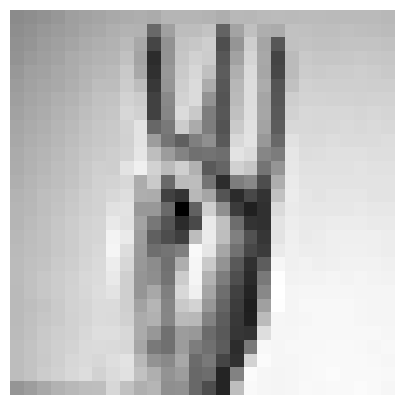

el valor predicho u


In [28]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {alphabet[y_test[rnd_idx]]}')
plot_number(x_test[rnd_idx].reshape(28,28))
pred=predict(x_test_tensor[rnd_idx].reshape(1, -1), model1)
print(f'el valor predicho {alphabet[pred]}')